In [1]:
# Download of Images for model training
from tqdm import tqdm_notebook as tqdm 
import requests
import math
import os
import zipfile

if not os.path.exists("data"):
    os.mkdir("data")
    
if not os.path.exists(os.path.join("data", "PetImages")):
    url = "https://downloads.codingcoursestv.eu/037%20-%20neuronale%20netze/PetImages.zip"
    # Streaming, so we can iterate over the response.
    r = requests.get(url, stream=True)

    # Total size in bytes.
    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    
    print("Downloading...")
    with open(os.path.join("data", "PetImages.zip"), 'wb') as f:
        for data in tqdm(r.iter_content(block_size), total=math.ceil(total_size//block_size), unit='KB', unit_divisor=1024, unit_scale=True):
            f.write(data)
            
    print("Download completed")
    print("Extracting...")
    
    zip_ref = zipfile.ZipFile(os.path.join("data", "PetImages.zip"), 'r')
    zip_ref.extractall(os.path.join("data"))
    zip_ref.close()
    
    print("Done!")
else:
    print("Die Dateien existieren bereits")

Downloading...


<ipython-input-1-359bb02690ac>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm(r.iter_content(block_size), total=math.ceil(total_size//block_size), unit='KB', unit_divisor=1024, unit_scale=True):


  0%|          | 0.00/795k [00:00<?, ?KB/s]

Download completed
Extracting...
Done!


In [1]:
# Read all images to numpy array
import os
import numpy as np
from tqdm import tqdm_notebook as tqdm
from PIL import Image

def read_images(path):
  files = os.listdir(path)
  files = [file for file in files if file[-4:] == ".jpg"]

  images = []
  # uses less file due to not enough RAM
  files = files[:2000]
  for file in tqdm(files):
    try:
      img = Image.open(os.path.join(path, file))
      img = img.resize((224, 224), Image.LANCZOS)
      img = img.convert("RGB")
      img = np.asarray(img)
      images.append(img)
    except OSError:
      pass

  return images;


cats = read_images(os.path.join("data", "PetImages", "Cat"))
dogs = read_images(os.path.join("data", "PetImages", "Dog"))

<ipython-input-1-af83b43d9d37>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm(files):


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

In [2]:
# generate x_train data + normalise them
x_cats = np.asarray(cats)
x_dogs = np.asarray(dogs)
x_train = np.concatenate([x_cats, x_dogs])
x_train = x_train.astype(np.float32) / 255.

# generate y_train data + normalise them
y_cats = np.ones(x_cats.shape[0])
y_dogs = np.zeros(x_dogs.shape[0])
y_train = np.concatenate([y_cats, y_dogs])
y_train = y_train.reshape(-1, 1)

print(x_train.shape)
print(y_train.shape)

(4000, 224, 224, 3)
(4000, 1)


In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(224, 224, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(1024, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer=Adam(learning_rate=0.00001), loss="binary_crossentropy", metrics=["acc"])

In [4]:
model.fit(x_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
63/63 [==============================] - 29s 279ms/step - loss: 0.6921 - acc: 0.5000
Epoch 2/50
63/63 [==============================] - 16s 258ms/step - loss: 0.6892 - acc: 0.5360
Epoch 3/50
63/63 [==============================] - 16s 251ms/step - loss: 0.6814 - acc: 0.5723
Epoch 4/50
63/63 [==============================] - 15s 245ms/step - loss: 0.6657 - acc: 0.6077
Epoch 5/50
63/63 [==============================] - 15s 245ms/step - loss: 0.6504 - acc: 0.6310
Epoch 6/50
63/63 [==============================] - 16s 249ms/step - loss: 0.6317 - acc: 0.6513
Epoch 7/50
63/63 [==============================] - 16s 250ms/step - loss: 0.6125 - acc: 0.6675
Epoch 8/50
63/63 [==============================] - 16s 251ms/step - loss: 0.6069 - acc: 0.6712
Epoch 9/50
63/63 [==============================] - 16s 249ms/step - loss: 0.5893 - acc: 0.6890
Epoch 10/50
63/63 [==============================] - 16s 250ms/step - loss: 0.5811 - acc: 0.7045
Epoch 11/50
63/63 [====================

In [5]:
model.evaluate(x_train, y_train)

125/125 [==============================] - 5s 38ms/step - loss: 0.2431 - acc: 0.9118


[0.24313528835773468, 0.9117500185966492]

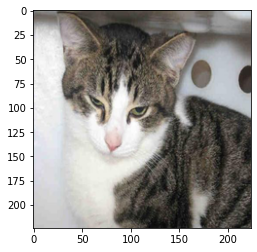

1/1 [==============================] - 0s 38ms/step
Cat: True; 80%


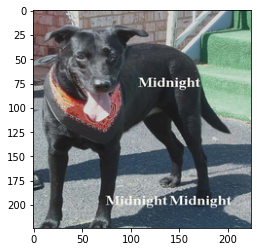

1/1 [==============================] - 0s 65ms/step
Cat: False; 9%


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def is_it_a_cat(path):
  res = False
  img = Image.open(path)

  img = img.convert("RGB")
  img = np.asarray(img.resize((224, 224), resample=Image.LANCZOS))
  img = img.astype(np.float32) / 255.

  plt.imshow(img)
  plt.show()

  img = img.reshape(1, 224, 224, 3)
  pred = model.predict(img)
  if (pred[0][0]) >= 0.8:
    res = True
  print("Cat: " + str(res) + "; " + str(round(pred[0][0] * 100)) + "%")
  return res;

res_cat = is_it_a_cat("data/PetImages/Cat/10371.jpg")
res_dog = is_it_a_cat("data/PetImages/Dog/10371.jpg")